## **Build a basic Binary Classifier from scratch for Kaggle diabetes dataset**

We will build a basic linear classifier with one input layer (linear) and 1 output layer (sigmoid) for the binary classification of Pima Indians diabetes classification dataset from Kaggle.

In order to reinforce the nomenclature and the basic design, we will first build it using just Numpy. We will then compare the performance of this cliassifier with a similar one built with PyTorch

### NOTE
All the data checking, preprocessing and splitting into Train, Validate and TEst sets are done for you. Therefore you can just focus on building the ANN.

We will use matplotlib and seaborn for plotting. Data handling is with pandas, and splitting is done with scikit learn. The classifier is developed using numpy.


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
import seaborn as sns # plotting
# NEEDED FOR CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In Google Colab, use the following code cell to upload the ML library and the data file

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

I have included some helper functions for this lab exercise in an small python library, Lab6_MLlib. Import that library as well.

In [2]:
import Lab6_MLlib

Import the dataset (a csv file) into Pandas (pd) dataframe

In [3]:
diab_df = pd.read_csv("diabetes.csv")

## **STEP 1: DATA VISUALIZATION TO UNDERSTAND YOUR DATA!**

Use Pandas inbuilt functions to get information and stats of the input data. Use Seaborn for diagnostic plots.

In [4]:
# PRINT OUT THE FIRST FEW LINES OF THE INPUT DATA FILE
# THE FIRST COLUMN IS JUST AN INDEX
# THE NEXT EIGHT COLUMNS ARE THE FEATURES (= x values)
# THE LAST COLUMN IS THE LABEL (= y value)
diab_df.head()

# Change col names to lower case. Makes typing easier!
diab_df.columns = map(str.lower, diab_df.columns)
colnam = diab_df.columns.tolist()
print(colnam)

['pregnancies', 'glucose', 'bloodpressure', 'skinthickness', 'insulin', 'bmi', 'diabetespedigreefunction', 'age', 'outcome']


In [5]:
# CHECK FOR MISSING, NULL OR NAN DATA VALUES IN ANY OF THE COLUMNS
diab_df.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

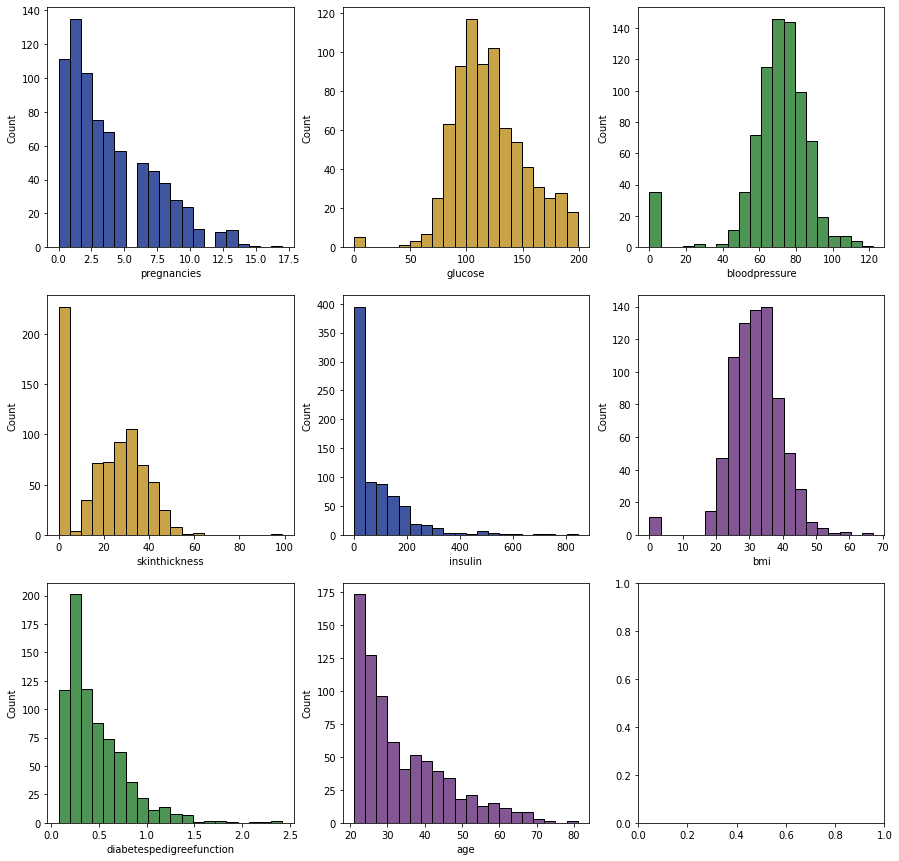

In [6]:
# PLOT THE DISTRIBUTIONS OF ALL THE FEATURES, CHECK FOR GAUSSIAN OR SKEWED DISTRIBUTIONS
sns.set_color_codes("dark")
fig, ax = plt.subplots(3,3, figsize=(15,15))
sns.histplot(diab_df.pregnancies, bins = 20, color='b',ax=ax[0,0]) 
sns.histplot(diab_df.glucose, bins = 20, color='y',ax=ax[0,1]) 
sns.histplot(diab_df.bloodpressure, bins = 20, color='g', ax=ax[0,2]) 
sns.histplot(diab_df.skinthickness, bins = 20, color='y', ax=ax[1,0])
sns.histplot(diab_df.insulin, bins = 20, color='b', ax=ax[1,1])
sns.histplot(diab_df.bmi, bins = 20, color='m', ax=ax[1,2]) 
sns.histplot(diab_df.diabetespedigreefunction, bins = 20, color='g', ax=ax[2,0]) 
sns.histplot(diab_df.age, bins = 20, color='m',ax=ax[2,1]) 


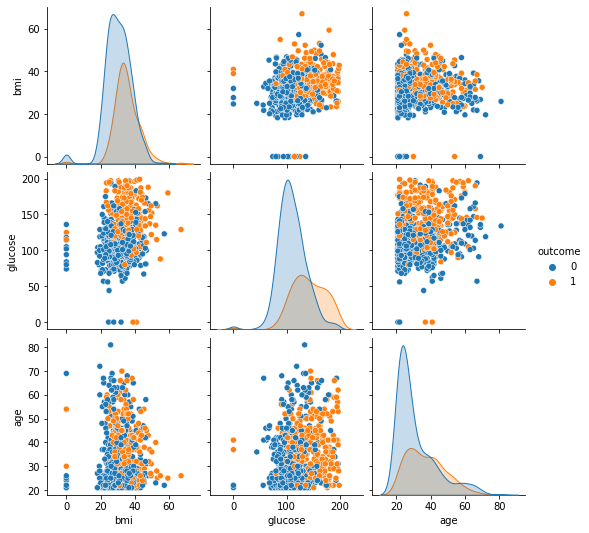

In [7]:
# CHECK FOR ANY UNDERLYING CORRELATIONS BETWEEN THE FEATURES
# WE COLOR THE DISTRIBUTIONS BY THE VALUES OF THE CORRESPONDING LABELS
# THIS SHOWS US IF THERE IS ANY BIAS IN THE SUBSET OF DATA REPRESENTING EACH OF THE TWO CLASSES
# FOR ILLUSTRATION, WE ARE ONLY PLOTTING THREE FEATURES, BUT THIS SHOULD BE DONE FOR FEATURES
pairplt = sns.pairplot(diab_df, vars=["bmi", "glucose", "age"], hue="outcome")

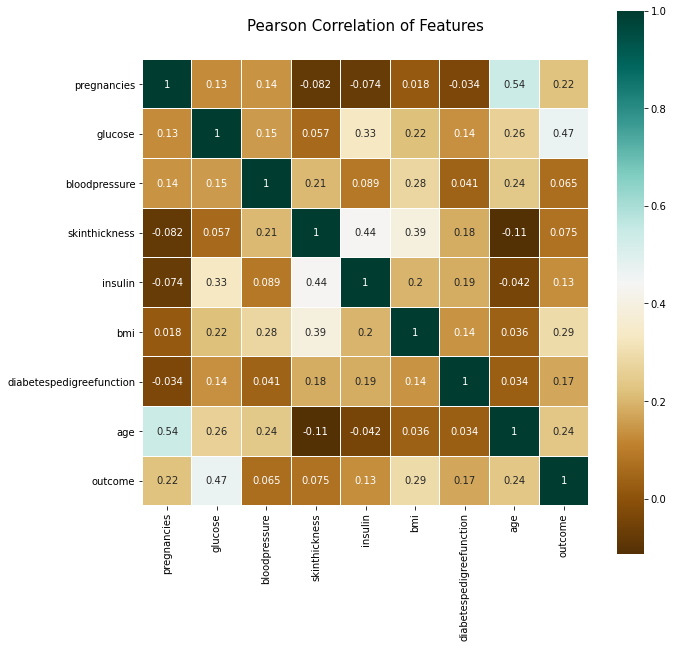

In [8]:
# PRINT OUT PEARSON CORRELATION COEFFICIENTS AMONGST ALL THE FEATURES

colormap = plt.cm.BrBG
plt.figure(figsize=(10,10));
plt.title('Pearson Correlation of Features', y=1.05, size=15);
corr = diab_df.corr()
sns.heatmap(corr, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);

## **STEP 2: DATA PREPROCESSING**

First split the data frame into the features and the labels. We will preprocess only the features.

Since many of the features do not show a gaussian distribution, for this dataset we will just scale between min and max values. Feel free to experiment later using zero mean and unit variance for all or some of the features.


In [9]:
# SPLIT THE DATA FRAME INTO LABELS AND FEATURES
# CHECK THE SHAPE (SIZE) OF EACH
labels = diab_df.outcome.values
labels = labels.reshape(labels.shape[0],1)
features = diab_df.drop(["outcome"], axis = 1).values
# features = diab_df.drop(["outcome"], axis = 1).to_numpy()
# features = features.to_numpy()
print('Shape of labels: ',labels.shape)
print('Shape of features: ',features.shape)


Shape of labels:  (768, 1)
Shape of features:  (768, 8)


## **STEP 3: DATA SPLITTING**

Do a three-way split of input data to subsets, train, validate and test datasets, using a ratio of train:validate:test = 80:10:10

**NOTE** Scikit-learn does only a two-way split, so do this in two steps

In [10]:
from sklearn.model_selection import train_test_split

# IN TWO STEPS, SPLIT DATA INTO TRAIN, VALIDATION AND TEST SETS
feat_train, feat_valtest, lab_train, lab_valtest = train_test_split(features, labels, test_size = 0.2, random_state = 42)
feat_val, feat_test, lab_val, lab_test = train_test_split(feat_valtest, lab_valtest, test_size = 0.5, random_state = 42)

print('Shape of train set: ',feat_train.shape)
print('Shape of validate set: ',feat_val.shape)
print('Shape of test set: ',feat_test.shape)
print('Shape of train labels: ',lab_train.shape)

train_siz = feat_train.shape[0]
val_siz = feat_val.shape[0]
test_siz = feat_test.shape[0]
n_feat = feat_train.shape[1]
print('Sizes of train, validate and test sets: %d, %d, %d' % (train_siz,val_siz,test_siz))
print('Number of features: %d' % (n_feat))


Shape of train set:  (614, 8)
Shape of validate set:  (77, 8)
Shape of test set:  (77, 8)
Shape of train labels:  (614, 1)
Sizes of train, validate and test sets: 614, 77, 77
Number of features: 8


(array([ 24.,   0.,   0.,   1.,   2.,   0.,   2.,   9.,  30.,  53.,  93.,
        120., 111.,  86.,  55.,  14.,   7.,   4.,   2.,   1.]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

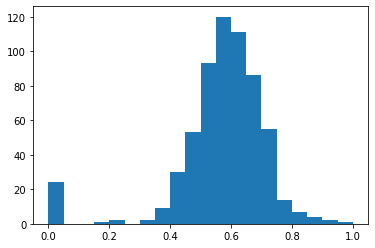

In [11]:
# rescale each feature between its min and max values
# IMPORTANT! ESTIMATE ONLY MAX, MIN FROM TRAIN FEATURES
max_vect = np.amax(feat_train,axis=0,keepdims=True)
min_vect = np.amin(feat_train,axis=0,keepdims=True)

# Normalize the train, val and test features
denom = (max_vect - min_vect)
feat_train = (feat_train - min_vect)/denom
feat_val = (feat_val - min_vect)/denom
feat_test = (feat_test - min_vect)/denom

# Check the normalization
plt.hist(feat_train[:,2],bins=20)

## **STEP 4: BUILD THE MODEL** 

### **FORWARD PASS**

Build the model in two stages
    1. Linear stage z = W.x + b
    2. Non-linear activation (sigmoid) a = sigmoid(z)
    
In this simple model the activation, a is also the output, y'

Write a function to do these two math operations. Be careful to keep track of dimensions


In [13]:
# define the sigmoid function
def sigmoid(z):
    activ = 1/(1+np.exp(-z))
    return activ

In [14]:
# DEFINE THE FUNCTION TO DO THE TWO OPERATIONS TO CALCULATE y' 
# LINEAR
# SIGMOID
# (THIS ALSO FORMS THE FORWARD PASS OF OUR MODEL)
def forward_pass(x,W,b):
    # Input: x = matrix of features [number of features, number of examples]
    # Weight: W = vector [1, number of features] (usually this would be a matrix)
    # Bias, b = scalar (usually this would be a vector)
    # output is y'
    
    z = np.dot(W,x) + b
    a = sigmoid(z)
    # transpose to match the shape of y
    y_prim = a.T
    return y_prim

In [15]:
# IF YOU DID THE ABOVE CODE PROPERLY, 
# THE FOLLOWING TWO PRINT STATEMENTS SHOULD GIVE THE SAME ANSWERS
W = np.ones((1,n_feat))
b = 0
xtmp = feat_train[0,:].T.reshape(n_feat,1)
print('Forward pass: %.3f' % (forward_pass(xtmp,W,b)))
print('Check val: %.3f' % (sigmoid(np.sum(xtmp))))

Forward pass: 0.654
Check val: 0.654


### **LOSS AND COST FUNCTIONS**

We will use Binary Cross Entropy loss and compute the cost as the average loss for all the train samples.

In [16]:
def CrossEntropyLoss(yprim, y):
    CE_loss = -y*np.log(yprim)-(1-y)*np.log(1-yprim)
    # print('CE_loss shape: ',CE_loss.shape)
    return CE_loss

## define cost function using CE loss
def CEcost(yprim,y):
    CE_cost = np.sum(CrossEntropyLoss(yprim, y))/y.shape[0]
    return CE_cost

### **BACKWARD PASS**

Compute the gradients. Since we are using BCE, the gradients are computed using quantities from the forward pass.

In [17]:
## define gradient of CE loss
def derv_BCEloss(yprim, y):
    numer = -(y - yprim)
    denom = yprim * (1. - yprim)
    derv = numer/denom
    return derv

## define gradient of sigmoid
def derv_sigmoid(z):
    sig_z = sigmoid(z)
    derv = sig_z * (1. - sig_z)
    return derv

## define gradient of BCEloss and sigmoid
def derv_BCEsig(yprim,y):
    derv = (yprim - y)
    return derv

## define graident of W and b
def derv_wb(x):
    derv_W = x
    derv_b = 1
    return derv_W,derv_b

## define the overall gradient
## compute the average over the training set
def grad_overall(x,yprim,y):
    dBCEsig = derv_BCEsig(yprim,y)
    derv_W,derv_b = derv_wb(x)
    dw = derv_W*dBCEsig.T
    db = derv_b*dBCEsig.T
    dw = np.sum(dw,axis=1)/y.shape[0]
    db = np.sum(db)/y.shape[0]
    wb_grad = {"dw": dw, "db": db}
    return wb_grad


### **PARAMETERS UPDATE**

Update W and b using the gradients, using a chosen learning rate, alph

In [18]:
# define the parameter upgrade
def parm_upgrade(W,b,wb_grad,alph):
    dw = wb_grad['dw']
    db = wb_grad['db']
    W = W - alph*dw
    b = b - alph*db
    return W,b

### **DEFINE THE TRAIN LOOP**

Use all the components defined above to build a complete training loop

In [19]:
def train_loop(x,y,W,b,alph,niter,nchks):
    # define lists to hold diagnostic output
    costval = []
    itrval = []
    for itr in range(niter):
        # forward pass
        yprim = forward_pass(x,W,b)
        # compute cost
        itr_cost = CEcost(yprim,y)
        # compute overall gradients
        wb_grad = grad_overall(x,yprim,y)
        # upgrade w,b and loop again
        W,b = parm_upgrade(W,b,wb_grad,alph)
        if ((itr % nchks) == 0):
            costval.append(itr_cost)
            itrval.append(itr)
    return W,b,costval,itrval
        

### **INITIALIZE THE WEIGHTS AND BIAS** 

The weights are usually set to some small random values. The bias is initialized to 0.
For Xavier initialization, see Glorot \& Bengio, 2010

In [20]:
## initialize weights and bias
def init_wb(siz_L,siz_L1):
    # return a weight matrix of dim siz_L, siz_L-1
    # initialized using a Xavier-like initialization
    w_mat = np.random.randn(siz_L,siz_L1)*np.sqrt(0.01/(siz_L + siz_L1))
    b_vect= np.zeros((siz_L,1))
    return w_mat,b_vect

# USE THE HELPER FUNCTION IN THE LIBRARY TO INITIALZIE W AND B
w_mat,b_vect = Lab6_MLlib.init_wb(1,n_feat)
print('Shape of w: ',w_mat.shape)
print('Shape of b: ',b_vect.shape)
print('Initial value of W: ',w_mat)

Shape of w:  (1, 8)
Shape of b:  (1, 1)
Initial value of W:  [[-0.02769282 -0.00813513 -0.01388773  0.00074498  0.0083865   0.05124032
  -0.0859002   0.05638734]]


## **STEP 5: RUN A FULL TRAINING LOOP**

To check how well the training is progressing, we will print out the cost function once every nchks steps. If everything is going well, you should see that the cost function gradually decreases, 'descends down the gradient'. The rate of descent can be tuned by the *hyperparameter*, alph, which is the *learning rate*

For plotting later, the iteration numbers and associated cost valuse are also saved in lists and returned by the function, train_loop

In [21]:
niter = 500
nchks = 50
alph = 1.2
# RUN THE TRAINING LOOP
W,b,costval,itrval = train_loop(feat_train.T,lab_train,w_mat,b_vect,alph,niter,nchks)
print('  Iter -- Cost Function: ')
for prt in range(len(itrval)):
    print('%6d %10.6f' % (itrval[prt],costval[prt]))

print('Weights before/after training: ')
for prt in range(n_feat):
    print('%10.6f %10.6f' % (w_mat[:,prt],W[:,prt]))

  Iter -- Cost Function: 
     0   0.693133
    50   0.582997
   100   0.547750
   150   0.527492
   200   0.514289
   250   0.504998
   300   0.498123
   350   0.492856
   400   0.488718
   450   0.485404
Weights before/after training: 
 -0.027693   0.953888
 -0.008135   4.837708
 -0.013888  -1.365626
  0.000745   0.219402
  0.008387  -0.163765
  0.051240   3.361533
 -0.085900   1.293851
  0.056387   2.093622


Plot the CE cost versus iteration

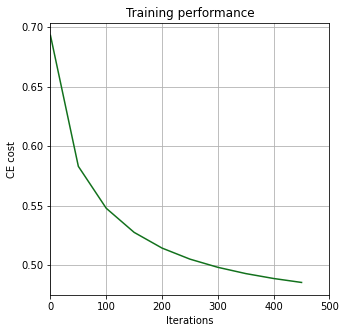

In [22]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
ax.plot(itrval,costval,color='g',linestyle='-')
ax.grid(True)
ax.set(xlim=(0,niter),
       xlabel="Iterations", ylabel="CE cost",
       title="Training performance");


## **STEP 6: VALIDATE THE TRAINED MODEL WITH THE VALIDATION SET. ALSO TUNE ANY HYPERPARAMETERS**

With the trained model, run a prediction using only the validation set (NOT YET THE TEST SET). Then compute the performance metrics to evaluate the performance. Keep track of these values. The functions needed to calculate or plot the performance metrics are all available in the library, Lab6_MLlib

This step is used to fine tune the **Hyperparameters** In the case of our simple binary classifier, we only have to tune the learning rate, alph


In [ ]:
## PREDICTION INVOLVES ONLY RUNNING THE FORWARD PASS
ypred_prob = forward_pass(feat_val.T,W,b)
print('Shape of prediction: ',ypred_prob.shape)
print('Shape of validation labels: ',lab_val.shape)


Calculate and print out the performance metrics and confusion matrix. Also plot the confusion matrix.

In [ ]:
# SET THE DECISION BOUNDARY HERE
# CHOOSE ANY VALUE BETWEEN 0 AND 1, AND SEE HOW THE PERFORMANCE CHANGES
dbry = 0.5

TP,FP,FN,TN,cmat,cmat_norm = Lab6_MLlib.comp_cm(ypred_prob,lab_val,dbry)
print('TP,FN,FP,TN: ',TP,FN,FP,TN)
print('Accuracy: %.2f' % ((TP+TN)/lab_val.shape[0]))
colormap=plt.cm.Blues
plt.figure(figsize=(5,5));
plt.title('Confusion Matrix', y=1.05, size=15);
sns.heatmap(cmat_norm, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);


Compute the full set of performance metrics, and print out

In [ ]:
accr,misclass,prevl,precs,recall,speci,FPR = Lab6_MLlib.perf_matrics(TP,FP,FN,TN,cmat,lab_val)

Create a ROC

In [ ]:
Y_va,PY_va_prob,PY_va = Lab6_MLlib.pltROC(lab_val,ypred_prob,dbry)

## **IMPORTANT NOTE: YOU CAN ITERATE STEPS 5 AND 6 AS MANY TIMES AS YOU WISH TO FINE TUNE THE MODEL. WHEN YOU ARE SATISFIED, DO A TEST OF YOUR PRODUCTION MODEL ON YOUR TEST SET**

The data in the test set represents data from the real world, since it is a dataset that the model has never seen before. It should perform equally on the test set as it did on the train and validation sets

In [ ]:
# CALCULATE THE PREDICTION ON THE TEST SET
ytest_prob = forward_pass(feat_test.T,W,b)
# CALCULATE THE PERFORMANCE AND CONFUSION METRICS
TP,FP,FN,TN,cmat,cmat_norm = Lab6_MLlib.comp_cm(ytest_prob,lab_test,dbry)
print('TP,FN,FP,TN: ',TP,FN,FP,TN)
print('Accuracy: %.2f' % ((TP+TN)/lab_test.shape[0]))
colormap=plt.cm.Blues
plt.figure(figsize=(5,5));
plt.title('Confusion Matrix', y=1.05, size=15);
sns.heatmap(cmat_norm, linewidths=0.1,vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True);
# CALCULATE AND PRINT OUT ALL OTHER METRICS
accr,misclass,prevl,precs,recall,speci,FPR = Lab6_MLlib.perf_matrics(TP,FP,FN,TN,cmat,lab_test)

# **BUILD A NETWORK USING PYTORCH FOR THE SAME DATASET**

In [ ]:
# IMPORT PYTORCH AND THE NECESSARY ASSOCIATED PACKAGES
import torch
from torch.autograd import Variable


Let's first define the architecture, number of layers, number of neurons in each layer, etc

    . Nsamp = number of samples (in train set or batch)
    . Dim_in = size of first hidden layer (number of features + 1)
    . Dim_out = size of output (=1 for our binary classification case)


In [ ]:
Nsamp, Dim_in, Dim_out = train_siz,n_feat,1
print('Chosen network params: Nsamp, Dim_in, Dim_out ',Nsamp, Dim_in, Dim_out)

### **READ THE PYTORCH DOCX TO UNDERSTAND THE DIFFERENT TYPES OF NN COMPONENTS AVAILABLE**

In [ ]:
# Using PyTorch torch.nn package is a good first start
# For more complex models, we can define classes
# The modules are put together like Lego blocks


# Basic: Linear + sigmoid
PyTmodel = torch.nn.Sequential(
       torch.nn.Linear(Dim_in, Dim_out),
       torch.nn.Sigmoid(),
)

### **DEFINE THE LOSS FUNCTION**

In [ ]:
# Various loss functions are available in torch.nn
#loss_fn = torch.nn.MSELoss(reduction='sum')
#loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss()


### **DEFINE FANCY STUFF, OPTIMIZERS, ETC**


In [ ]:
# torch.optim also provides various optimizers
learning_rate = 1.2
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(PyTmodel.parameters(), lr=learning_rate)

### **WE ARE READY TO WRITE OUR TRAINING LOOP!**

## **IMPORTANT: NOTE THAT WE DID NOT HAVE TO WRITE THE GRADIENT CALCULATION AND BACK PROP!! PYTORCH AUTOMATICALLY DOES THIS FOR US**

In [ ]:
# We first need to convert numpy arrays to Torch tensors
feat_train_PyT = torch.from_numpy(feat_train) # (N samples, D_in features)
lab_train_PyT = torch.from_numpy(lab_train)

# Run the training loop
niter = 500
nchks = 50
for itr in range(niter):
    # Forward pass
    y_pred = PyTmodel(Variable(feat_train_PyT.float()))
    # Loss
    loss = loss_fn(y_pred, Variable(lab_train_PyT.float()))
    if ((itr % nchks) == 0):
        print(itr, loss.item())
    # Run the back prop (using optimizer)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

## **CONTINUE ONWARD, CHECK THE PERFORMANCE ON THE VALIDATION DATASET, THEN TUNE THE HYPERPARAMETERS. FINALLY, RUN ON THE TEST SET AND SEE HOW MUCH BETTER THE TWO-LAYER MODEL CAN DO**